In [27]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import torch 
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
import wandb
import argparse 
import importlib.util
import inspect
import random

from src.models.models_util import CESM_Dataset
from src.models.models import UNetRes3
from src.utils import util_cesm
from src import config_cesm
from src.models.losses import WeightedMSELoss
import src.config as config_era5

reference_grid = util_cesm.generate_sps_grid()

def roll_acc(acc):
    return xr.concat(
        [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
        dim="lead_time"
    )

def aggregate_acc(acc, dim):
    if dim == ("x", "y"):
        acc = acc.groupby("start_prediction_month.month").mean("start_prediction_month")
    else: 
        raise ValueError()
        
    # roll in lead time so that it gets lined up
    return roll_acc(acc)

def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        acc = aggregate_acc(acc, dim)

    return acc

### Regrid obs

In [1]:
import xarray as xr
import xesmf as xe
import os
import numpy as np 
import pandas as pd 
import argparse 

from src.utils import util_cesm
from src import config_cesm
import src.config as config_era5


In [2]:
cesm_to_era5_varnames = {
    "temp": "sea_surface_temperature",
    "icefrac": "sea_ice_cover",
    "psl": "mean_sea_level_pressure",
    "geopotential": "geopotential_500hPa"
}

cesm_to_era5_short_varnames = {
    "temp": "sst",
    "icefrac": "siconc",
    "psl": "msl",
    "geopotential": "z"
}

def transform_obs_to_cesm_format(var_name, output_grid, savedir): 
    os.makedirs(savedir, exist_ok=True)
    savepath = os.path.join(savedir, f"{var_name}_obs.nc")
    if (os.path.exists(savepath)): return 

    ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/{cesm_to_era5_varnames[var_name]}.nc")).sel(latitude=slice(-30,-90))
    weight_file = f'{config_cesm.DATA_DIRECTORY}/cesm_lens/grids/era5_small_to_sps_bilinear_regridding_weights.nc'
    
    if os.path.exists(weight_file):
        regridder = xe.Regridder(ds, output_grid, 'bilinear', weights=weight_file, 
                                ignore_degenerate=True, reuse_weights=True, periodic=True)
    else:
        regridder = xe.Regridder(ds, output_grid, 'bilinear', filename=weight_file, 
                                ignore_degenerate=True, reuse_weights=False, periodic=True)
    ds_regridded = regridder(ds)
    ds_regridded = ds_regridded.sel(expver=1).combine_first(ds_regridded.sel(expver=5))

    # rename variable
    ds_regridded = ds_regridded.rename({cesm_to_era5_short_varnames[var_name]: var_name})

    # save
    ds_regridded.to_netcdf(savepath)

In [ ]:
sps_grid = util_cesm.generate_sps_grid()

for var_name in ["temp", "psl", "icefrac", "geopotential"]:
    print(f"transforming {var_name}")
    transform_obs_to_cesm_format(var_name, sps_grid, os.path.join(config_cesm.DATA_DIRECTORY, "ERA5/cesm_format"))

### Test normalization
This is a temporary thing

In [ ]:
xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc"))

In [98]:
import src.experiment_configs.config_simple_plus_psl as config
import pandas as pd 

data_split_name = "simple_plus_psl" 
data_split_settings = config.DATA_SPLIT_SETTINGS
max_lead_months = 6

normalized_data = []
for var_name in ["temp"]:
    if config.INPUT_CONFIG[var_name]['include'] and config.INPUT_CONFIG[var_name]['norm']:
        max_lag_months = config.INPUT_CONFIG[var_name]['lag']
        merged_ds = xr.open_dataset(os.path.join(config_cesm.RAW_DATA_DIRECTORY, f"{var_name}_combined.nc"))
        cesm_da = merged_ds[var_name]

        divide_by_stdev = config.INPUT_CONFIG[var_name]['divide_by_stdev']

        # Load the observational data
        ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/{var_name}_obs.nc"))
        obs_da = ds[var_name] 

        # convert SST from K to C 
        if var_name == "temp":
            obs_da -= 273.15 

        # Compute the normalization statistics over the CESM dataset
        # this normalization is over the whole spatiotemporal domain 
        if data_split_settings["split_by"] == "time": 
            all_times = util_cesm.get_start_prediction_months(data_split_settings)

            # all_times gives all time coordinates that are accessed, given variable leads and lags
            all_times = pd.date_range(all_times[0] - pd.DateOffset(months=max_lag_months), 
                                    all_times[-1] + pd.DateOffset(months=max_lead_months-1),
                                    freq="MS")        
            cesm_da = cesm_da.sel(time=all_times, member_id=data_split_settings["member_ids"]) 
            da_train_subset = cesm_da.sel(time=data_split_settings["train"])

        elif data_split_settings["split_by"] == "ensemble_member": 
            all_member_ids = data_split_settings["train"] + data_split_settings["val"] + data_split_settings["test"]
            
            all_times = data_split_settings["time_range"]
            all_times = pd.date_range(all_times[0] - pd.DateOffset(months=max_lag_months), 
                                    all_times[-1] + pd.DateOffset(months=max_lead_months-1),
                                    freq="MS") 
            cesm_da = cesm_da.sel(member_id=all_member_ids, time=all_times) 
            da_train_subset = cesm_da.sel(member_id=data_split_settings["train"])
        
        # monthly_means = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
        #     data_split_name, f"{var_name}_mean.nc"))

        monthly_means = da_train_subset.groupby('time.month').mean(("time","x","y","member_id"))
        monthly_stdev = da_train_subset.groupby('time.month').std(("time","x","y","member_id"))

        # normalize
        months = obs_da['time'].dt.month

        if divide_by_stdev: 
            normalized_da = (obs_da - monthly_means.sel(month=months)) / monthly_stdev.sel(month=months)
            # monthly_stdevs = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
            #     data_split_name, f"{var_name}_stdev.nc"))
        
            # normalized_da = xr.apply_ufunc(
            #     util_cesm.normalize,
            #     da,
            #     monthly_means.sel(month=months),
            #     monthly_stdevs.sel(month=months),
            #     var_name,
            #     output_dtypes=[da.dtype],
            #     dask="allowed"
            # )
        else: 
            normalized_da = obs_da - monthly_means.sel(month=months)
        
        # normalized_data.append(normalized_da)


In [ ]:
normalized_da.isel(time=200).plot()

In [ ]:
normalized_da.isel(time=205).temp.plot()
plt.title("1995-02-01 normalized SST")
plt.savefig("figures/known_issues/distribution_shift_sst_example2.jpg", dpi=300, bbox_inches='tight')

In [ ]:
ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/temp_obs.nc"))
da = ds["temp"] 

# convert SST from K to C 
da -= 273.15 

obs_means = da.groupby("time.month").mean("time")
obs_stdev = da.groupby("time.month").std("time")

data_split_name = "simple_plus_psl" 

cesm_means = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
    data_split_name, f"temp_mean.nc"))["temp"]
 
cesm_stdevs = xr.open_dataset(os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "normalized_inputs", 
    data_split_name, f"temp_stdev.nc"))["temp"]


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharex=True, sharey=True)

axs[0,0].contourf(obs_means.sel(month=2) - cesm_means.sel(month=2), cmap="RdBu_r", levels=np.arange(-4, 4.5, 0.5))
cax = axs[1,0].contourf(obs_means.sel(month=9) - cesm_means.sel(month=9), cmap="RdBu_r", levels=np.arange(-4, 4.5, 0.5), extend='both')
axs[0,0].set_ylabel("February")
axs[0,0].set_title("Mean SST_obs minus SST_cesm", fontsize=10)
axs[0,1].set_title("Stdev SST_obs minus SST_cesm", fontsize=10)
axs[0,0].set_yticks([])
axs[0,0].set_xticks([])

axs[0,1].contourf(obs_stdev.sel(month=2) - cesm_stdevs.sel(month=2), cmap="RdBu_r", levels=np.arange(-1, 1.2, 0.2))
axs[1,0].set_ylabel("September")

cax2 = axs[1,1].contourf(obs_stdev.sel(month=9) - cesm_stdevs.sel(month=9), cmap="RdBu_r", levels=np.arange(-1, 1.2, 0.2), extend='both')

cbar_ax = fig.add_axes([0.15,0.05, 0.3, 0.02])
cbar_ax2 = fig.add_axes([0.57, 0.05, 0.3, 0.02])
plt.colorbar(cax, cax=cbar_ax, label=r'˚C', orientation='horizontal', extend="both")
plt.colorbar(cax2, cax=cbar_ax2, label=r'˚C', orientation='horizontal')
plt.savefig("figures/known_issues/distribution_shift_sst.jpg", dpi=300, bbox_inches='tight')



### Data loader

In [2]:
ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/icefrac_obs.nc"))
ntime = len(ds.time) - 12 - 6

train_subset = np.arange(0, (7/10) * ntime, dtype=int)
val_subset = np.arange((7/10) * ntime, (8/10) * ntime, dtype=int)
test_subset = np.arange((8/10) * ntime, ntime, dtype=int)

data_split_settings = {
    "train": train_subset,
    "val": val_subset,
    "test": test_subset
}


def detrend_quadratic(da, time_dim='time'):
    time_vals = da[time_dim].dt.year + da[time_dim].dt.month / 12.0
    time_numeric = xr.DataArray(time_vals, coords={time_dim: da[time_dim]}, dims=time_dim)

    spatial_dims = [d for d in da.dims if d not in [time_dim, 'member_id']]
    da_stacked = da.stack(space=spatial_dims)
    detrended = da_stacked.copy()

    coeffs_all = []

    for month in range(1, 13):
        sel = da_stacked[time_dim].dt.month == month
        if not sel.any(): continue

        t = time_numeric.sel({time_dim: sel})
        Y = da_stacked.sel({time_dim: sel})
        X = np.stack([np.ones_like(t), t, t**2], axis=1)

        beta = np.linalg.solve(X.T @ X, X.T @ Y.values)  # (3, space)
        coeffs_all.append((month, beta))

        trend = xr.DataArray((X @ beta).astype(Y.dtype), coords=Y.coords, dims=Y.dims)
        detrended.loc[{time_dim: sel}] = da_stacked.sel({time_dim: sel}) - trend

    detrended_unstacked = detrended.unstack('space')

    # Build coeff DataArray
    coeffs = np.full((12, 3) + (da_stacked.sizes['space'],), np.nan, dtype=da.dtype)
    for month, beta in coeffs_all:
        coeffs[month - 1] = beta 

    coeff_da = xr.DataArray(
        coeffs,
        dims=('month', 'coeff', 'space'),
        coords={
            'month': np.arange(1, 13),
            'coeff': ['const', 'linear', 'quadratic'],
            'space': da_stacked.coords['space']
        }
    ).unstack('space')

    return detrended_unstacked, coeff_da

def load_data_da_dict(config, detrend=False):
    data_da_dict = {}

    for var_name in config.INPUT_CONFIG.keys(): 
        if config.INPUT_CONFIG[var_name]['include'] and config.INPUT_CONFIG[var_name]['norm']:
            max_lag_months = config.INPUT_CONFIG[var_name]['lag']
            divide_by_stdev = config.INPUT_CONFIG[var_name]['divide_by_stdev']
            use_min_max = config.INPUT_CONFIG[var_name]["use_min_max"]

            # Load the observational data
            ds = xr.open_dataset(os.path.join(config_cesm.DATA_DIRECTORY, f"ERA5/cesm_format/{var_name}_obs.nc"))
            obs_da = ds[var_name] 
            months = obs_da['time'].dt.month
            da_train_subset = obs_da[np.concatenate((np.arange(12, dtype=int), train_subset + int(12)))]

            if divide_by_stdev: 
                normalized_da = (obs_da - monthly_means.sel(month=months)) / monthly_stdev.sel(month=months)
            else:    
                if use_min_max:
                    print(f"normalizing {var_name} with min max")
                    monthly_mins = da_train_subset.groupby("time.month").min(dim=("time")).load()
                    monthly_maxs = da_train_subset.groupby("time.month").max(dim=("time")).load()
                    normalized_da = (obs_da - monthly_mins.sel(month=months)) / (monthly_maxs.sel(month=months) - monthly_mins.sel(month=months))
                else:
                    monthly_means = da_train_subset.groupby("time.month").mean(dim="time").load()
                    normalized_da = obs_da - monthly_means.sel(month=months)
            
            if detrend: 
                normalized_da, coeffs = detrend_quadratic(normalized_da)

            # artificial cap: sst to [-5, 5]
            if var_name == "temp":
                normalized_da = xr.where(normalized_da > 5, 5, normalized_da)
                normalized_da = xr.where(normalized_da < -5, -5, normalized_da)
            data_da_dict[var_name] = normalized_da.drop_vars("month")

    return data_da_dict

def get_obs_start_prediction_months(data_da_dict, data_split_settings):
    max_lag = 12
    first_month = data_da_dict["icefrac"].time[max_lag].item()
    last_month = data_da_dict["icefrac"].time[-config.MAX_LEAD_MONTHS].item()
    return pd.date_range(first_month, last_month, freq="MS")


def save_obs_inputs(input_config, save_path, data_da_dict, data_split_settings):
    """
    Writes a model-ready input file (.nc) for each ensemble member to save_path

    Param:
        (dict)      input_config
        (string)    save_path
    """

    # get some auxiliary data
    x_coords = data_da_dict["icefrac"].x.data
    y_coords = data_da_dict["icefrac"].y.data
    land_mask = np.isnan(data_da_dict["icefrac"].isel(time=0)).data
    land_mask = np.transpose(land_mask.reshape(1, 80, 80), [0, 2, 1]) # for some reason, x and y get switched

    start_prediction_months = get_obs_start_prediction_months(data_da_dict, data_split_settings)
    save_name = os.path.join(save_path, f"inputs_obs.nc")
    if os.path.exists(save_name):
       return

    da_list = []
    for start_prediction_month in start_prediction_months:
        time_da_list = []
        for input_var, input_var_params in input_config.items():
            if not input_var_params["include"]: 
                continue 
            
            if not input_var_params["auxiliary"]:
                prediction_input_months = pd.date_range(start_prediction_month - pd.DateOffset(months=input_var_params["lag"]), 
                                                        start_prediction_month - pd.DateOffset(months=1), freq="MS")

                input_data = data_da_dict[input_var].sel(time=prediction_input_months)

                # mask out NaN values
                input_data = input_data.fillna(0)

                # rename the time coordinate to channel 
                lag = input_var_params["lag"]
                input_data = input_data.assign_coords(time=[f"{input_var}_lag{lag+1-i}" for i in range(1, lag+1)])
                input_data = input_data.rename({"time": "channel"})
            else:
                if input_var == "cosine_of_init_month":
                    input_data = xr.DataArray(
                        np.full((1, 80, 80), np.cos(2 * np.pi * start_prediction_month.month / 12)),
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                elif input_var == "sine_of_init_month":
                    input_data = xr.DataArray(
                        np.full((1, 80, 80), np.sin(2 * np.pi * start_prediction_month.month / 12)),
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                elif input_var == "land_mask": 
                    input_data = xr.DataArray(
                        land_mask, 
                        dims=["channel", "x", "y"],
                        coords={"channel": [input_var], "x": x_coords, "y": y_coords},
                    )
                else: 
                    raise NotImplementedError()

            # add a coordinate to denote the start prediction month (time origin)
            input_data = input_data.assign_coords(start_prediction_month=start_prediction_month)

            time_da_list.append(input_data)

        da_list.append(xr.concat(time_da_list, dim="channel", coords='minimal', compat='override'))

    da_merged = xr.concat(da_list, dim="start_prediction_month", coords="minimal", compat='override')

    # rechunk
    da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "channel":-1})

    # clean up singleton dimensions
    if "z_t" in da_merged.dims: 
        da_merged = da_merged.drop_vars("z_t")
    if "lev" in da_merged.dims:
        da_merged = da_merged.drop_vars("lev")


    print("done! Saving...")
    da_merged.to_dataset(name="data").to_netcdf(save_name)
    da_merged.close()


def save_obs_targets(input_da_dict, input_config, target_config, 
                    save_path, max_lead_months, data_split_settings):
    """
    Writes a model-ready targets file (.nc) for each ensemble member to save_path
    
    Param:
        (dict)      input_config
        (dict)      target_config
        (string)    save_path
        (int)       max_lead_months
        (dict)      data_split_settings
    """

    if not target_config["predict_anom"]:
        raise NotImplementedError()
    else:
        da = input_da_dict["icefrac"]

    start_prediction_months = get_obs_start_prediction_months(input_da_dict, data_split_settings)
    save_name = os.path.join(save_path, f"targets_obs.nc")
    if os.path.exists(save_name):
        return

    time_da_list = []

    for start_prediction_month in start_prediction_months:
        prediction_target_months = pd.date_range(start_prediction_month, 
                                                start_prediction_month + pd.DateOffset(months=max_lead_months-1), 
                                                freq="MS")
        
        target_data = da.sel(time=prediction_target_months)

        # mask out nans
        target_data = target_data.fillna(0)

        target_data = target_data.assign_coords(time=np.arange(1,7))
        target_data = target_data.rename({"time": "lead_time"}) 

        # add a coordinate to denote the start prediction month (time origin)
        target_data = target_data.assign_coords(start_prediction_month=start_prediction_month)

        time_da_list.append(target_data)

    da_merged = xr.concat(time_da_list, dim="start_prediction_month", coords='minimal', compat='override')

    da_merged = da_merged.chunk(chunks={"start_prediction_month":12, "lead_time":-1})
    
    da_merged.to_dataset(name="data").to_netcdf(save_name)
    da_merged.close()




In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

for config in [config2, config4]:
    save_path = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config.DATA_CONFIG_NAME)

    data_da_dict = load_data_da_dict(config, detrend=False)

    save_obs_inputs(config.INPUT_CONFIG, save_path, data_da_dict, data_split_settings)

    save_obs_targets(data_da_dict, config.INPUT_CONFIG, config.TARGET_CONFIG, 
                    save_path, 6, data_split_settings)


In [3]:

class Obs_Dataset(torch.utils.data.Dataset):
    def __init__(self, split, data_config_name, data_split_settings):
        self.data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", data_config_name)
        self.split = split

        # Open and keep datasets in memory (or use .load() to load them immediately)
        self.inputs = xr.open_dataset(os.path.join(self.data_dir, "inputs_obs.nc")).data
        self.targets = xr.open_dataset(os.path.join(self.data_dir, "targets_obs.nc")).data

        # Build a global index of samples
        time_values = self.inputs["start_prediction_month"].values
        self.samples = [(time_values[start_idx], int(start_idx)) for start_idx in data_split_settings[split]]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        start_prediction_month, start_idx = self.samples[idx]

        input_sample = self.inputs.isel(start_prediction_month=start_idx).load().values.copy()
        target_sample = self.targets.isel(start_prediction_month=start_idx).load().values.copy()

        max_lead_months = target_sample.shape[0]
        start_prediction_months = pd.date_range(
            start_prediction_month,
            start_prediction_month + pd.DateOffset(months=max_lead_months - 1),
            freq="MS"
        )

        time_npy = np.column_stack((start_prediction_months.year, start_prediction_months.month))

        sample = {
            "input": torch.tensor(input_sample, dtype=torch.float32),
            "target": torch.tensor(target_sample, dtype=torch.float32),
            "start_prediction_month": time_npy,
        }

        return sample


In [22]:
def train_epoch(model, dataloader, optimizer, loss_fn, device, epoch, total_epochs, global_step):
    model.train()
    epoch_loss = 0
    loss_fn_params = inspect.signature(loss_fn.forward).parameters

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{total_epochs} [Train]")

    for _, batch in progress_bar:
        inputs, targets = batch["input"].to(device), batch["target"].to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        loss_kwargs = {"prediction": predictions, "target": targets}
        if "target_months" in loss_fn_params:
            loss_kwargs["target_months"] = batch["start_prediction_month"][:, :, 1].to(device)

        loss = loss_fn(**loss_kwargs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

        # Log batch-level training loss
        wandb.log({"train_loss": loss.item()}, step=global_step)
        global_step += 1

    return epoch_loss / len(dataloader), global_step

def validate_epoch(model, dataloader, loss_fn, device, epoch, total_epochs, global_step):
    model.eval()
    total_squared_error = 0.0
    total_count = 0
    epoch_loss = 0 
    loss_fn_params = inspect.signature(loss_fn.forward).parameters

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}/{total_epochs} [Val]")

    with torch.no_grad():
        for _, batch in progress_bar:
            inputs, targets = batch["input"].to(device), batch["target"].to(device)
            predictions = model(inputs)

            # Compute loss 
            loss_kwargs = {"prediction": predictions, "target": targets}
            if "target_months" in loss_fn_params:
                loss_kwargs["target_months"] = batch["start_prediction_month"][:, :, 1].to(device)
            loss = loss_fn(**loss_kwargs)

            # Compute RMSE
            squared_error = (predictions - targets) ** 2
            total_squared_error += squared_error.sum().item()
            total_count += targets.numel()

            batch_rmse = torch.sqrt(squared_error.mean()).item()
            progress_bar.set_postfix({"Batch RMSE": batch_rmse})
            wandb.log({
                "val_loss": loss.item(),
                "val_rmse": batch_rmse
            }, step=global_step)
            
            epoch_loss += loss.item()
            global_step += 1

    epoch_rmse = (total_squared_error / total_count) ** 0.5
    return epoch_rmse, epoch_loss / len(dataloader), global_step

from torch.optim.lr_scheduler import CosineAnnealingLR

def train(data_config, save_path):
    wandb.init(settings=wandb.Settings(console="off"))
    config = wandb.config
    train_dataset = Obs_Dataset("train", data_config.DATA_CONFIG_NAME, data_split_settings)
    val_dataset = Obs_Dataset("val", data_config.DATA_CONFIG_NAME, data_split_settings)

    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    in_channels = util_cesm.get_num_input_channels(data_config.INPUT_CONFIG)
    out_channels = util_cesm.get_num_output_channels(data_config.MAX_LEAD_MONTHS, data_config.TARGET_CONFIG)

    model = UNetRes3(
        in_channels=in_channels, 
        out_channels=out_channels, 
        n_channels_factor=config.n_channels_factor,
        predict_anomalies=data_config.TARGET_CONFIG["predict_anom"]
    ).to(device)

    optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs)

    loss_function_args = data_config.LOSS_FUNCTION_ARGS 
    loss_function_args["apply_month_weights"] = bool(config.loss_function_args)
    loss_fn = WeightedMSELoss(device=device, model=model, **loss_function_args)

    num_epochs = config.num_epochs
    global_step = 0
    best_val_rmse = float('inf')
    run_id = wandb.run.id 
    best_model_path = os.path.join(save_path, f"{data_config.DATA_CONFIG_NAME}_{run_id}_best.pt")
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss, global_step = train_epoch(
            model, train_dataloader, optimizer, loss_fn, device, epoch, num_epochs, global_step
        )

        val_rmse, val_loss, global_step = validate_epoch(
            model, val_dataloader, loss_fn, device, epoch, num_epochs, global_step
        )

        # Log epoch stats and learning rate
        current_lr = scheduler.get_last_lr()[0]
        wandb.log({
            "epoch": epoch,
            "epoch_train_loss": train_loss,
            "epoch_val_loss": val_loss, 
            "epoch_val_rmse": val_rmse,
            "lr": current_lr,
        }, step=global_step)

        scheduler.step()

        # Early stopping 
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        if best_val_rmse < float("inf"):
            wandb.log({"best_val_rmse": best_val_rmse}, step=global_step)

def evaluate(model, dataloader):
    channels, x_dim, y_dim = 6, 80, 80

    pred_list = []
    truth_list = []
    time_list = []

    # Populate the Dataset with predictions
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", unit="sample"):
            inputs = batch["input"].to(device)
            targets = batch["target"]
            predictions = model(inputs).cpu().numpy()

            # since batch size = 1, get the only sample in the batch
            predictions = predictions[0]
            targets = targets[0]

            # Extract metadata
            start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0, 0]
            start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)
            time_list.append(start_prediction_month)

            pred_da = xr.DataArray(
                predictions,
                dims=["lead_time", "y", "x"],
                coords={
                    "lead_time": np.arange(1, channels + 1),
                    "y": reference_grid.y.values,
                    "x": reference_grid.x.values,
                }
            )
            truth_da = xr.DataArray(
                targets,
                dims=["lead_time", "y", "x"],
                coords={
                    "lead_time": np.arange(1, channels + 1),
                    "y": reference_grid.y.values,
                    "x": reference_grid.x.values,
                }
            )

            pred_list.append(pred_da)
            truth_list.append(truth_da)

    # Stack results along new time coordinate
    ds_pred = xr.Dataset({
        "icefrac": xr.concat(pred_list, dim=pd.Index(time_list, name="start_prediction_month"))
    })
    ds_truth = xr.Dataset({
        "icefrac": xr.concat(truth_list, dim=pd.Index(time_list, name="start_prediction_month"))
    })

    return ds_pred, ds_truth


## Sweep 1 (input2)
Results at https://wandb.ai/ychnli-stanford-university/sea-ice-prediction/sweeps/ki0k0l49

In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config2

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'epoch_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 5e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-3
        },
        'batch_size': {
            'values': [1, 2, 4, 8, 16, 32, 64] 
        },
        'n_channels_factor': {
            'values': [0.5, 0.75, 1]
        },
        'num_epochs': {
            'value': 50
        },
        'loss_function_args': {
            'values': [0, 1] # 0 = don't apply monthly weights; 1 = apply monthly weights
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep"
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path), count=50)


## Sweep 2 (input2)
Refined ranges (removed large learning rates, use larger batch sizes)

Results: https://wandb.ai/ychnli-stanford-university/sea-ice-prediction/sweeps/85pc8f4o

In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config2

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'best_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 2e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-4
        },
        'batch_size': {
            'values': [20, 32, 50, 64] 
        },
        'n_channels_factor': {
            'values': [0.5, 0.75, 1]
        },
        'num_epochs': {
            'value': 100
        },
        'loss_function_args': {
            'value': 1
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep"
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path), count=50)


In [23]:
import src.experiment_configs.exp1_inputs.input2 as config2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataloaders
train_dataset = Obs_Dataset("train", config2.DATA_CONFIG_NAME, data_split_settings)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

test_dataset = Obs_Dataset("test", config2.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


# model (best = jbns1cqy)
run_id = 'jbns1cqy'
checkpoint_path = f"/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep/seaice_plus_auxiliary_{run_id}_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

in_channels = util_cesm.get_num_input_channels(config2.INPUT_CONFIG)
out_channels = util_cesm.get_num_output_channels(config2.MAX_LEAD_MONTHS, config2.TARGET_CONFIG)
model = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config2.TARGET_CONFIG["predict_anom"]).to(device)

model.load_state_dict(checkpoint)

# evaluate on test 
ds_pred_train, ds_truth_train = evaluate(model, train_dataloader)
ds_pred_test, ds_truth_test = evaluate(model, test_dataloader)

Evaluating: 100%|██████████| 108/108 [00:00<00:00, 188.73sample/s]


In [29]:
test_acc = calculate_acc(ds_pred_test.icefrac, ds_truth_test.icefrac, dim=("x","y"), aggregate=True)
train_acc = calculate_acc(ds_pred_train.icefrac, ds_truth_train.icefrac, dim=("x","y"), aggregate=True)

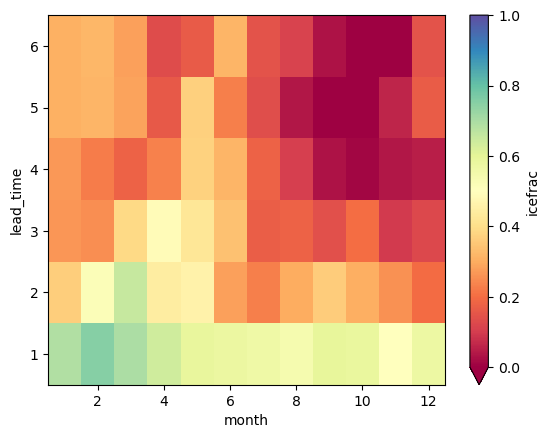

In [36]:
test_acc.plot(vmin=0, vmax=1, cmap="Spectral")

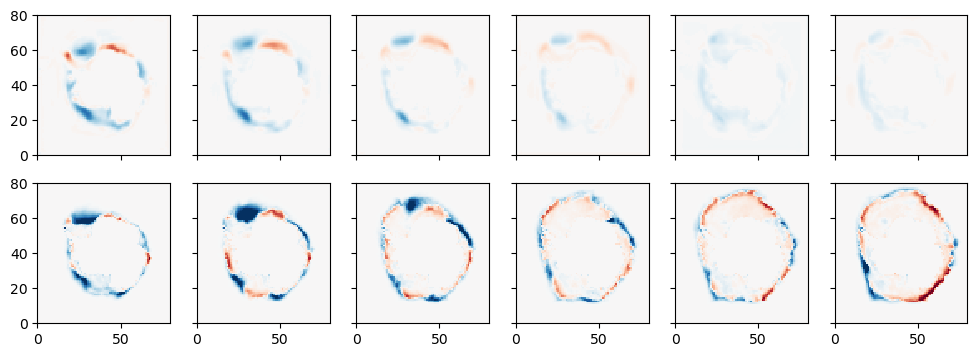

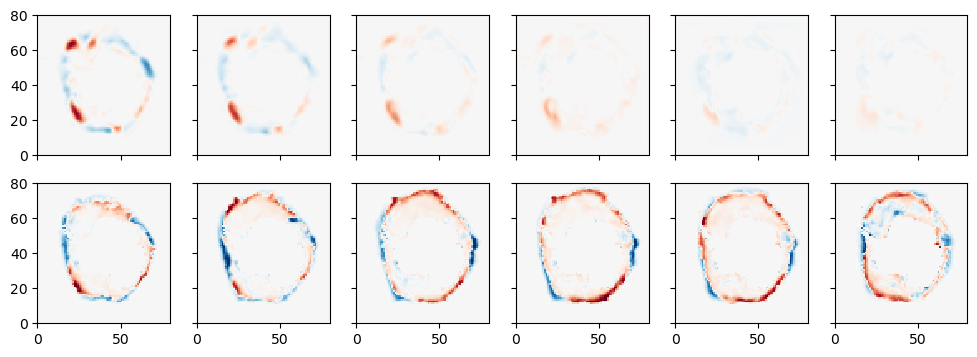

In [58]:
def plot_pred_example(ds_pred, ds_truth, start_prediction_month):
    fig, axs = plt.subplots(figsize=(12, 4), nrows=2, ncols=6, sharex=True, sharey=True)

    for i in range(6):
        pred = ds_pred.icefrac.isel(start_prediction_month=start_prediction_month, lead_time=i)
        truth = ds_truth.icefrac.isel(start_prediction_month=start_prediction_month, lead_time=i)

        axs[0,i].pcolormesh(pred, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
        axs[1,i].pcolormesh(truth, vmin=-0.5, vmax=0.5, cmap="RdBu_r")

    plt.show()

plot_pred_example(ds_pred_test, ds_truth_test, 51)
plot_pred_example(ds_pred_test, ds_truth_test, 65)

## Sweep 3 (input4)

In [ ]:
import src.experiment_configs.exp1_inputs.input4 as config4
import src.experiment_configs.exp1_inputs.input2 as config2

data_config = config4

sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'best_val_rmse',
        'goal': 'minimize'
    },
    'parameters': {
        'lr': {
            'min': 1e-5,
            'max': 2e-3 
        },
        'weight_decay': {
            'min': 0.0,
            'max': 1e-4
        },
        'batch_size': {
            'values': [20, 32, 50, 64] 
        },
        'n_channels_factor': {
            'values': [0.5, 0.75, 1]
        },
        'num_epochs': {
            'value': 100
        },
        'loss_function_args': {
            'value': 1
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

save_path = "/scratch/users/yucli/sicpred_models/exp3_obs_hypsweep"
wandb.agent(sweep_id, function=lambda: train(data_config, save_path=save_path), count=50)


In [ ]:
data_config = config2

sweep_id = wandb.sweep(sweep_config, project="sea-ice-prediction")

wandb.agent(sweep_id, function=lambda: train(config2, save_path="sweep_checkpoints"), count=30)


In [ ]:
# train model 
start_epoch = 0
total_epochs = 20
for epoch in range(start_epoch, total_epochs + 1):
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch, total_epochs)
    val_loss = validate_epoch(model, val_dataloader, loss_fn, device, epoch, total_epochs)

    # Log metrics to WandB
    # wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

    # Save a checkpoint
    # file_name = f"{config.MODEL}_{config.EXPERIMENT_NAME}_member_{ensemble_id}_epoch_{epoch}.pth"
    # checkpoint_path = os.path.join(save_dir, file_name)
    # if epoch % config.CHECKPOINT_INTERVAL == 0:
    #     torch.save({
    #         "epoch": epoch,
    #         "model_state_dict": model.state_dict(),
    #         "optimizer_state_dict": optimizer.state_dict(),
    #     }, checkpoint_path)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
test_dataset = Obs_Dataset("test", config.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model.eval()

time_coords = inputs_da.start_prediction_month[data_split_settings["test"]]
channels, x_dim, y_dim = config.MAX_LEAD_MONTHS, 80, 80

ds_pred = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

ds_truth = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

# Populate the Dataset with predictions
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating", unit="sample")): 
        inputs = batch["input"].to(device)
        targets = batch["target"]
        predictions = model(inputs).cpu().numpy()  # Move predictions to CPU
        
        # since batch size = 1, get the only sample in the batch
        predictions = predictions[0]

        # Extract metadata
        start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0,0]
        start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)

        # Find the appropriate indices
        time_idx = list(time_coords).index(start_prediction_month)

        ds_pred["icefrac"][time_idx, :, :, :] = predictions
        ds_truth["icefrac"][time_idx, :, :, :] = targets[0]

In [87]:
ds_truth.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_truth.nc")
ds_pred.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_pred_input2_nopretrain.nc")

In [108]:
pred_anom = ds_pred.icefrac
truth_anom = ds_truth.icefrac

def calc_acc(pred_anom, truth_anom):
    dim = ("x", "y")
    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))
    acc = acc.groupby("start_prediction_month.month").mean("start_prediction_month")

    acc = xr.concat(
        [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
        dim="lead_time"
    )

    return acc

In [94]:
checkpoint_path = "/scratch/users/yucli/sicpred_models/exp2_vol4/UNetRes3_exp2_vol4_member_0_epoch_10.pth"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

model_pt = UNetRes3(in_channels=in_channels, 
                out_channels=out_channels, 
                predict_anomalies=config.TARGET_CONFIG["predict_anom"]).to(device)
model_pt.load_state_dict(checkpoint["model_state_dict"])

optimizer = Adam(model_pt.parameters(), lr=0.0005)

if config.LOSS_FUNCTION == "MSE": 
    loss_fn = WeightedMSELoss(device=device, **config.LOSS_FUNCTION_ARGS)

In [ ]:
test_dataset = Obs_Dataset("test", config.DATA_CONFIG_NAME, data_split_settings)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model_pt.eval()

time_coords = inputs_da.start_prediction_month[data_split_settings["test"]]
channels, x_dim, y_dim = config.MAX_LEAD_MONTHS, 80, 80

ds_pred = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

ds_truth = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

# Populate the Dataset with predictions
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating", unit="sample")): 
        inputs = batch["input"].to(device)
        targets = batch["target"]
        predictions = model_pt(inputs).cpu().numpy()  # Move predictions to CPU
        
        # since batch size = 1, get the only sample in the batch
        predictions = predictions[0]

        # Extract metadata
        start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0,0]
        start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)

        # Find the appropriate indices
        time_idx = list(time_coords).index(start_prediction_month)

        ds_pred["icefrac"][time_idx, :, :, :] = predictions
        ds_truth["icefrac"][time_idx, :, :, :] = targets[0]

ds_pred.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_pred_input2_pretrain_nofinetune.nc")

In [ ]:
calc_acc(ds_pred.icefrac, ds_truth.icefrac).plot(vmin=0, vmax=1, cmap="Spectral")

In [ ]:
# train model 
start_epoch = 0
total_epochs = 10
for epoch in range(start_epoch, total_epochs + 1):
    train_loss = train_epoch(model_pt, train_dataloader, optimizer, loss_fn, device, epoch, total_epochs)
    val_loss = validate_epoch(model_pt, val_dataloader, loss_fn, device, epoch, total_epochs)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
model_pt.eval()

ds_pred = xr.Dataset(
    {
        "icefrac": (
            ["start_prediction_month", "lead_time", "y", "x"],
            np.full((len(time_coords), channels, y_dim, x_dim), 
                    np.nan, dtype=np.float32)
        )
    },
    coords={
        "start_prediction_month": time_coords,
        "lead_time": np.arange(1, channels + 1),
        "y": reference_grid.y.values,
        "x": reference_grid.x.values,
    }
)

# Populate the Dataset with predictions
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating", unit="sample")): 
        inputs = batch["input"].to(device)
        targets = batch["target"]
        predictions = model_pt(inputs).cpu().numpy()  # Move predictions to CPU
        
        # since batch size = 1, get the only sample in the batch
        predictions = predictions[0]

        # Extract metadata
        start_year, start_month = batch["start_prediction_month"].cpu().numpy()[0,0]
        start_prediction_month = pd.Timestamp(year=start_year, month=start_month, day=1)

        # Find the appropriate indices
        time_idx = list(time_coords).index(start_prediction_month)

        ds_pred["icefrac"][time_idx, :, :, :] = predictions

ds_pred.to_netcdf("/scratch/users/yucli/sicpred_model_predictions/exp3/obs_pred_input2_pretrain_finetune_10epochs.nc")

In [ ]:
calc_acc(ds_pred.icefrac, ds_truth.icefrac).plot(vmin=0, vmax=1, cmap="Spectral")